# Binary Classification

Load Libraries

In [1]:
# Import package dependencies
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ml_metrics import rmse
import matplotlib.pyplot as plt

Load Data

In [2]:
dataRaw = pd.read_csv('final_project.csv', header=0)
dataRaw.shape

(160000, 51)

In [3]:
# Create training and testing sets (cross-validation not needed)
train_set = dataRaw.sample(frac=0.7, random_state=100)
test_set = dataRaw[~dataRaw.isin(train_set)].dropna()
print(train_set.shape[0])
print(test_set.shape[0])

112000
47543


In [4]:
#Missing Data after imputation
dtype_data=test_set.dtypes.reset_index()
dtype_data.columns=["Count","ColumnType"]
dtype_data.groupby("ColumnType").aggregate('count').reset_index()

missing_data=test_set.isnull().sum(axis=0).reset_index()
missing_data.columns=['ColumnName','MissingCount']
missing_data=missing_data.ix[missing_data['MissingCount']>0]
missing_data=missing_data.sort_values(by='MissingCount')

missing_data = missing_data.merge(dtype_data,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_data

D:\Masters\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,ColumnName,MissingCount,Count,ColumnType


In [5]:
# set train_set as data
train_set.head()
## Copy train_set into data 
data=train_set.copy()
data.shape

(112000, 51)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112000 entries, 102622 to 110262
Data columns (total 51 columns):
x0     111983 non-null float64
x1     111979 non-null float64
x2     111974 non-null float64
x3     111973 non-null float64
x4     111982 non-null float64
x5     111970 non-null float64
x6     111981 non-null float64
x7     111980 non-null float64
x8     111989 non-null float64
x9     111976 non-null float64
x10    111970 non-null float64
x11    111979 non-null float64
x12    111973 non-null float64
x13    111984 non-null float64
x14    111979 non-null float64
x15    111979 non-null float64
x16    111983 non-null float64
x17    111980 non-null float64
x18    111971 non-null float64
x19    111973 non-null float64
x20    111972 non-null float64
x21    111981 non-null float64
x22    111981 non-null float64
x23    111967 non-null float64
x24    111979 non-null object
x25    111984 non-null float64
x26    111974 non-null float64
x27    111978 non-null float64
x28    111973 non

There is no duplicated rows in the dataset.

In [7]:
# Select duplicate rows except first occurrence based on all columns
duplicateData = data[data.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateData.count())

Duplicate Rows except first occurrence based on all columns are :
x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x24    0
x25    0
x26    0
x27    0
x28    0
x29    0
x30    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    0
x40    0
x41    0
x42    0
x43    0
x44    0
x45    0
x46    0
x47    0
x48    0
x49    0
y      0
dtype: int64


## Categorical Data
Description of the categorical variables. As per the table below, there are only three true catergorical columns. The other two are currency and percents.

In [8]:
# Describe the Categorical Objects
list_include = ['object']
data.describe(include=list_include).T

,count,unique,top,freq
x24,111979,3,asia,97150
x29,111979,12,July,31958
x30,111976,5,wednesday,71209
x32,111978,12,0.01%,28378
x37,111986,96170,$185.79,5


for x32 and x37, we would need to remove the % and $ symbols and convert them into floats.

In [9]:
# For x32 remove the '%' sign and change it to float -- This is a percent
data['x32']=data['x32'].str.replace('%','').astype(float)

# For x37 remove the '$' sign and change it to float -- This is currency
data['x37']=data['x37'].str.replace('$','').astype(float)

data['x24']=data['x24'].str.replace('euorpe','europe')

data['x29']=data['x29'].str.replace('Dev','Dec')
data['x29']=data['x29'].str.replace('sept.','Sep')

data['x30']=data['x30'].str.replace('thurday','thursday')

In [10]:
# Test Set
# For x32 remove the '%' sign and change it to float -- This is a percent
test_set['x32']=test_set['x32'].str.replace('%','').astype(float)

# For x37 remove the '$' sign and change it to float -- This is currency
test_set['x37']=test_set['x37'].str.replace('$','').astype(float)

test_set['x24']=test_set['x24'].str.replace('euorpe','europe')

test_set['x29']=test_set['x29'].replace('Dev','Dec')
test_set['x29']=test_set['x29'].replace('sept.','Sep')

test_set['x30']=test_set['x30'].replace('thurday','thursday')


In [11]:
# Object Description after the changes to x32 and x37 
list_include = ['object']
data.describe(include=list_include).T

,count,unique,top,freq
x24,111979,3,asia,97150
x29,111979,12,July,31958
x30,111976,5,wednesday,71209


In [12]:
#Categorical Values
list_include = ['object']
unique_values_dict = {}
for col in data.select_dtypes(include=list_include).columns:
        unique_value = str(data[col].unique())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  ['asia' 'europe' 'america' nan]
['x24']
--------------------------------------------------
Columns containing the unique values :  ['Aug' 'May' 'Jun' 'Apr' 'July' 'Sep' 'Oct' 'Mar' 'Nov' 'Feb' nan
 'January' 'Dec']
['x29']
--------------------------------------------------
Columns containing the unique values :  ['thursday' 'wednesday' 'tuesday' 'monday' 'friday' nan]
['x30']
--------------------------------------------------


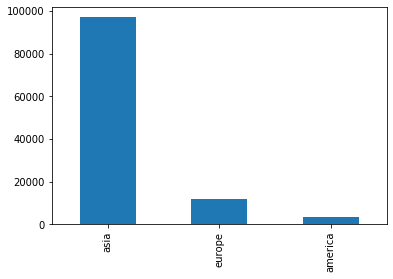

In [13]:
#continents
data['x24'].value_counts().plot(kind='bar')

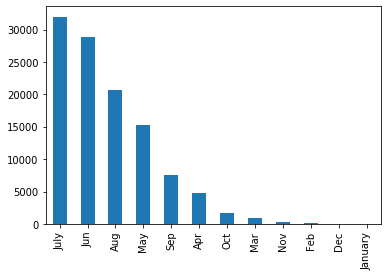

In [14]:
#Months
data['x29'].value_counts().plot(kind='bar')

The value of 'Dev' is not a valid month. These records will be removed from the dataset.

In [15]:
data.reset_index(inplace = True)
data.shape

(112000, 52)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112000 entries, 0 to 111999
Data columns (total 52 columns):
index    112000 non-null int64
x0       111983 non-null float64
x1       111979 non-null float64
x2       111974 non-null float64
x3       111973 non-null float64
x4       111982 non-null float64
x5       111970 non-null float64
x6       111981 non-null float64
x7       111980 non-null float64
x8       111989 non-null float64
x9       111976 non-null float64
x10      111970 non-null float64
x11      111979 non-null float64
x12      111973 non-null float64
x13      111984 non-null float64
x14      111979 non-null float64
x15      111979 non-null float64
x16      111983 non-null float64
x17      111980 non-null float64
x18      111971 non-null float64
x19      111973 non-null float64
x20      111972 non-null float64
x21      111981 non-null float64
x22      111981 non-null float64
x23      111967 non-null float64
x24      111979 non-null object
x25      111984 non-null float64
x

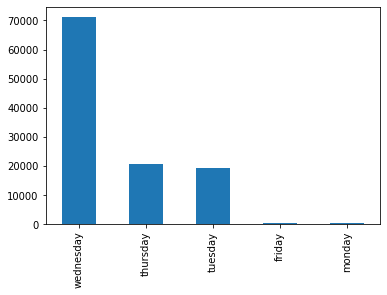

In [17]:
#Weekdays
data['x30'].value_counts().plot(kind='bar')

## Numerical Data
Fload Description 

In [18]:
# Describe the Float Objects
list_include = ['float64','int64']
data.describe(include=list_include).T

,count,mean,std,min,25%,50%,75%,max
index,112000.0,79962.360875,46155.551195,0.000000,40064.750000,79838.500000,119924.250000,159999.000000
x0,111983.0,-0.000979,0.371875,-1.592635,-0.252223,-0.001789,0.248880,1.600849
x1,111979.0,0.007555,6.346783,-26.278302,-4.271856,0.008812,4.293438,27.988178
x2,111974.0,-1.145874,13.279365,-59.394048,-10.121200,-1.342199,7.861490,63.545653
x3,111973.0,-0.016764,8.059457,-35.476594,-5.451664,-0.019624,5.443923,38.906025
x4,111982.0,0.011740,6.389589,-28.467536,-4.310078,0.006119,4.318409,26.247812
x5,111970.0,0.008855,7.669111,-33.822988,-5.162998,0.002691,5.199222,35.550110
x6,111981.0,-1.664879,19.307055,-86.354483,-14.714034,-1.951373,11.431334,92.390605
x7,111980.0,-7.777956,30.495080,-181.506976,-27.407624,-7.073838,12.066706,149.150634
x8,111989.0,-0.036945,8.914084,-37.691045,-6.052883,-0.005901,5.965870,39.049831


In [19]:
#Missing Data
dtype_data=data.dtypes.reset_index()
dtype_data.columns=["Count","ColumnType"]
dtype_data.groupby("ColumnType").aggregate('count').reset_index()

missing_data=data.isnull().sum(axis=0).reset_index()
missing_data.columns=['ColumnName','MissingCount']
missing_data=missing_data.ix[missing_data['MissingCount']>0]
missing_data=missing_data.sort_values(by='MissingCount')

missing_data = missing_data.merge(dtype_data,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_data

D:\Masters\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,ColumnName,MissingCount,Count,ColumnType
0,x8,11,x8,float64
1,x37,14,x37,float64
2,x13,16,x13,float64
3,x25,16,x25,float64
4,x0,17,x0,float64
5,x16,17,x16,float64
6,x42,17,x42,float64
7,x39,17,x39,float64
8,x4,18,x4,float64
9,x22,19,x22,float64


From the 160,000 records in the dataset, the maximum number of empty values in a given column is 47. For this case it looks to be at Random and we are replacing those missing values with the median.

In [20]:
#imputation of all the missing values with the median for all continuous values.
list_include=['float64']
for col in data.select_dtypes(include=list_include).columns:
    data[col] = data[col].fillna(data[col].median())

Missing Values After Imputation

In [21]:
#Missing Data after imputation
dtype_data=data.dtypes.reset_index()
dtype_data.columns=["Count","ColumnType"]
dtype_data.groupby("ColumnType").aggregate('count').reset_index()

missing_data=data.isnull().sum(axis=0).reset_index()
missing_data.columns=['ColumnName','MissingCount']
missing_data=missing_data.ix[missing_data['MissingCount']>0]
missing_data=missing_data.sort_values(by='MissingCount')

missing_data = missing_data.merge(dtype_data,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_data

D:\Masters\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,ColumnName,MissingCount,Count,ColumnType
0,x24,21,x24,object
1,x29,21,x29,object
2,x30,24,x30,object


### Scale Data

The imputation for the categorical values is the mode. We would use the most common value for each of the fields. The amount of missing values is not many in comparison to the total of the dataset.

In [22]:
# Impute the categorical values with the Mode. 
list_include=['object']
for col in data.select_dtypes(include=list_include).columns:
    dataMode=data[col].mode()
    data[col] = data[col].fillna(dataMode[0]).astype(object)
    print(dataMode[0])

asia
July
wednesday


In [23]:
#Missing Data after imputation of the categorical values.
dtype_data=data.dtypes.reset_index()
dtype_data.columns=["Count","ColumnType"]
dtype_data.groupby("ColumnType").aggregate('count').reset_index()

missing_data=data.isnull().sum(axis=0).reset_index()
missing_data.columns=['ColumnName','MissingCount']
missing_data=missing_data.ix[missing_data['MissingCount']>0]
missing_data=missing_data.sort_values(by='MissingCount')

missing_data = missing_data.merge(dtype_data,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_data

D:\Masters\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,ColumnName,MissingCount,Count,ColumnType


The table does not show any more empty values. All the NA values have now being inputed.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112000 entries, 0 to 111999
Data columns (total 52 columns):
index    112000 non-null int64
x0       112000 non-null float64
x1       112000 non-null float64
x2       112000 non-null float64
x3       112000 non-null float64
x4       112000 non-null float64
x5       112000 non-null float64
x6       112000 non-null float64
x7       112000 non-null float64
x8       112000 non-null float64
x9       112000 non-null float64
x10      112000 non-null float64
x11      112000 non-null float64
x12      112000 non-null float64
x13      112000 non-null float64
x14      112000 non-null float64
x15      112000 non-null float64
x16      112000 non-null float64
x17      112000 non-null float64
x18      112000 non-null float64
x19      112000 non-null float64
x20      112000 non-null float64
x21      112000 non-null float64
x22      112000 non-null float64
x23      112000 non-null float64
x24      112000 non-null object
x25      112000 non-null float64
x

## Target Value

0    67042
1    44958
Name: y, dtype: int64


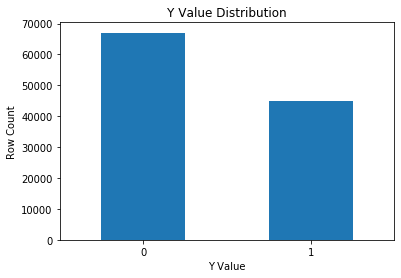

In [25]:
data['y'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Y Value')
plt.ylabel('Row Count')
plt.title('Y Value Distribution')
print(data['y'].value_counts())

In [26]:
data.groupby('y').mean().T

y,0,1
index,80052.048865,79828.616887
x0,-0.001046,-0.000880
x1,0.005446,0.010699
x2,-0.584264,-1.983470
x3,-0.006206,-0.032510
x4,0.013474,0.009152
x5,-0.006063,0.031096
x6,-0.849266,-2.881254
x7,-8.220099,-7.118313
x8,-0.008103,-0.079947


In [27]:
data.groupby('x24').mean().T

x24,america,asia,europe
index,80575.585710,80000.336777,79477.143753
x0,-0.000534,-0.001073,-0.000320
x1,0.002385,0.007581,0.008753
x2,0.461222,-1.294792,-0.343574
x3,-0.307987,-0.004651,-0.038054
x4,0.072355,0.016835,-0.047427
x5,-0.029396,0.008559,0.021797
x6,0.670582,-1.880842,-0.502527
x7,16.600472,-6.968136,-21.222577
x8,0.069796,-0.061529,0.139084


In [28]:
data.groupby('x29').mean().T

x29,Apr,Aug,Dec,Feb,January,July,Jun,Mar,May,Nov,Oct,Sep
index,79262.741372,80045.871523,89794.933333,85891.268041,76492.833333,79859.073204,79990.674785,77898.025200,80308.370954,8.032703e+04,81168.725294,79662.857276
x0,-0.004027,0.001227,0.114571,0.060053,0.009507,-0.002740,-0.001267,0.001556,-0.001119,2.694100e-02,-0.004584,0.002439
x1,0.003409,-0.012346,-2.579571,-1.002715,-2.953182,0.006223,0.030973,0.268577,-0.029653,-7.112519e-01,0.245519,0.014197
x2,-1.371531,-1.082496,2.794462,-2.162428,2.738886,-1.206505,-0.990136,-0.606937,-1.212009,-1.689601e+00,-1.435837,-1.364125
x3,-0.112404,-0.110752,-3.385732,0.477781,6.491403,-0.016201,0.016676,-0.561222,0.070058,-3.077521e-01,0.041339,0.048801
x4,0.147665,0.051750,-2.268896,0.538744,-2.854617,-0.002398,0.004426,-0.225864,-0.027278,1.103256e-02,-0.070539,0.029762
x5,0.032441,0.105981,0.007132,0.136938,-1.770379,-0.022915,0.031384,0.118557,-0.029283,1.426060e+00,-0.144722,-0.168539
x6,-1.997889,-1.571081,4.062938,-2.836802,3.982135,-1.754352,-1.440551,-0.882441,-1.757892,-2.456552e+00,-2.087600,-1.979570
x7,-8.631848,-7.715804,-1.585831,-6.184743,-14.379470,-7.677188,-7.904736,-7.906760,-7.714826,-6.867468e+00,-7.383710,-7.605164
x8,-0.003151,0.001700,2.895092,0.532369,3.388706,-0.035015,-0.069967,-0.319346,-0.012418,-6.865766e-01,-0.143852,-0.035187


In [29]:
data.groupby('x30').mean().T

x30,friday,monday,thursday,tuesday,wednesday
index,80022.671875,81631.017544,80090.469052,79498.891061,80043.475524
x0,-0.011925,0.023177,-0.003280,-0.000014,-0.000634
x1,0.305955,0.494459,-0.006564,-0.082830,0.032361
x2,-0.459638,-0.998075,-1.126379,-1.077525,-1.174648
x3,0.192944,-0.313474,0.025618,-0.020533,-0.027698
x4,-0.773826,0.148119,0.011153,0.041451,0.007379
x5,0.179238,0.066696,-0.037924,0.068889,0.004797
x6,-0.668279,-1.451127,-1.635142,-1.567691,-1.706480
x7,-4.071244,-9.055025,-7.753054,-7.558795,-7.858627
x8,0.186644,0.369941,-0.053667,-0.182117,0.004359


One Hot encoding for the categorical variables

In [30]:
list_include=['object']
for col in data.select_dtypes(include=list_include).columns:
    oneHot = pd.get_dummies(data[col])
    data = data.drop(col,axis=1)
    data = data.join(oneHot)
data.head().T

,0,1,2,3,4
index,102622.000000,28494.000000,74270.000000,14592.000000,127246.000000
x0,0.491504,0.517572,-0.057574,0.661645,-0.361890
x1,0.314115,-0.955143,4.325903,6.178227,-7.029364
x2,23.265738,-11.284554,-8.303166,5.104874,-7.274896
x3,5.481985,8.103776,4.429269,2.225417,-11.787074
...,...,...,...,...,...
friday,0.000000,0.000000,0.000000,0.000000,0.000000
monday,0.000000,0.000000,0.000000,0.000000,0.000000
thursday,1.000000,0.000000,0.000000,0.000000,0.000000
tuesday,0.000000,0.000000,0.000000,1.000000,1.000000


In [31]:
#one hot encoding for test set
list_include=['object']
for col in test_set.select_dtypes(include=list_include).columns:
    oneHot = pd.get_dummies(test_set[col])
    test_set = test_set.drop(col,axis=1)
    test_set = test_set.join(oneHot)
test_set.head().T

,2,4,9,10,11
x0,-0.321707,-0.273366,-0.349073,-0.333224,0.336104
x1,-1.429819,0.306326,3.334116,1.138614,3.737029
x2,12.251561,-11.352593,-3.355872,11.346697,-6.419190
x3,6.586874,1.676758,-0.796302,0.104432,2.604201
x4,-5.304647,2.928441,-0.900425,0.819080,-0.996173
...,...,...,...,...,...
friday,0.000000,0.000000,0.000000,0.000000,0.000000
monday,0.000000,0.000000,0.000000,0.000000,0.000000
thursday,0.000000,0.000000,0.000000,0.000000,0.000000
tuesday,0.000000,1.000000,0.000000,0.000000,1.000000


In [32]:
#list_include=['object']
#for col in scaled_data.select_dtypes(include=list_include).columns:
#    oneHot = pd.get_dummies(data[col])
#    data = scaled_data.drop(col,axis=1)
#    data = scaled_data.join(oneHot)
#scaled_data.head().T

Scale Train Data

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform( data.iloc[:, 1:])

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: median values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[12],scaler.min_[12]))
multiplied_by = scaler.scale_[12]
added = scaler.min_[12]

scaled_data = pd.DataFrame(scaled_data, columns =  data.iloc[:, 1:].columns.values)
scaled_data.shape

Note: median values were scaled by multiplying by 0.0072777332 and adding 0.466692


(112000, 68)

Scale Test Data

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_Tdata = scaler.fit_transform( test_set.iloc[:, 0:])

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: median values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[12],scaler.min_[12]))
multiplied_by = scaler.scale_[12]
added = scaler.min_[12]

scaled_Tdata = pd.DataFrame(scaled_Tdata, columns =  test_set.iloc[:, 0:].columns.values)
scaled_Tdata.shape

Note: median values were scaled by multiplying by 0.0076059094 and adding 0.488284


(47543, 68)

x0


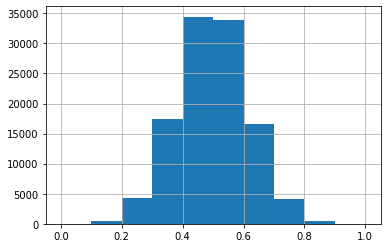

x1


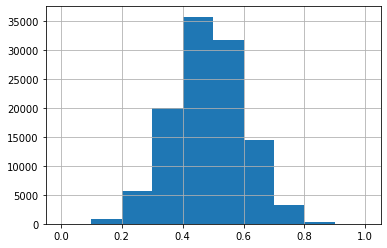

x2


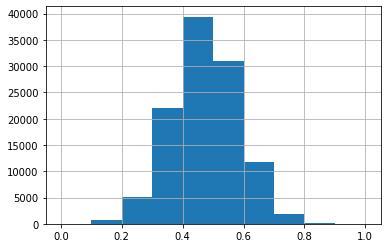

x3


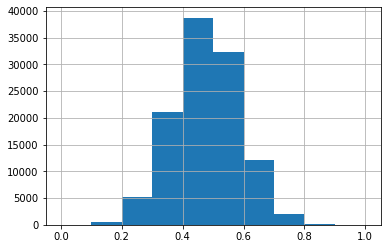

x4


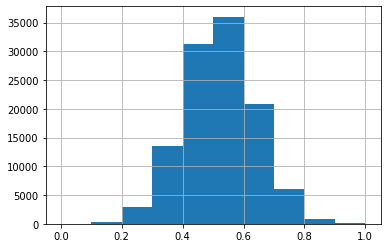

x5


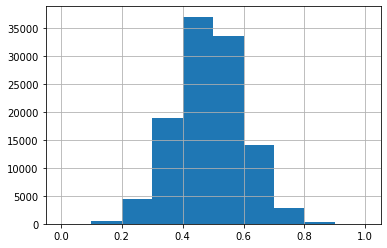

x6


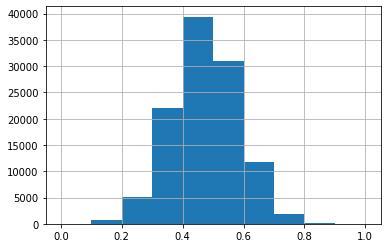

x7


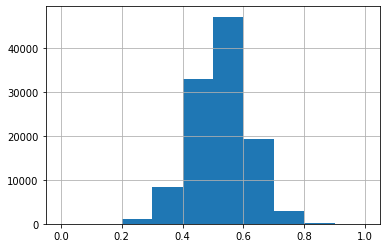

x8


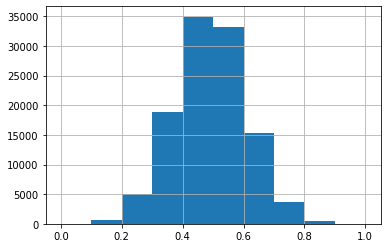

x9


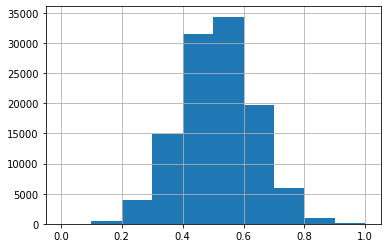

x10


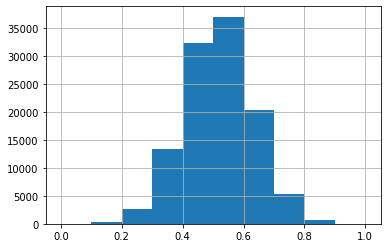

x11


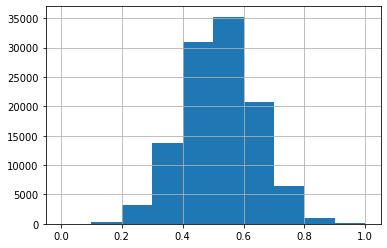

x12


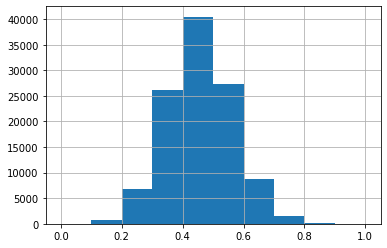

x13


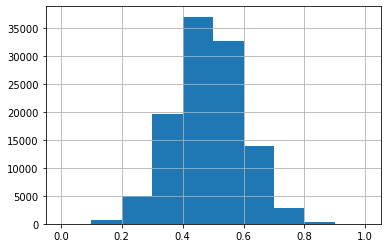

x14


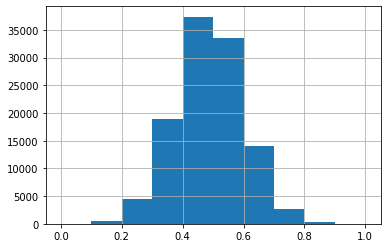

x15


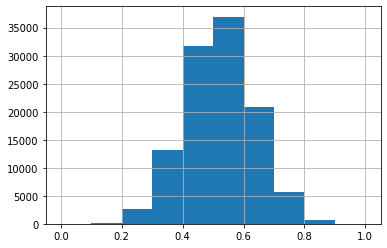

x16


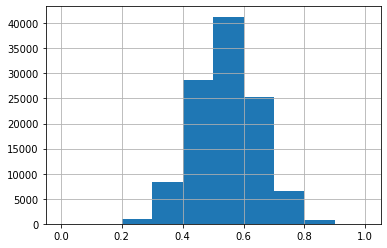

x17


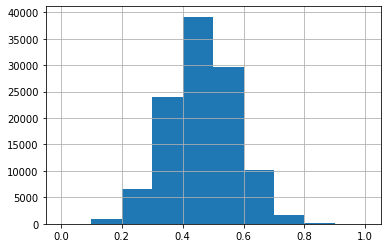

x18


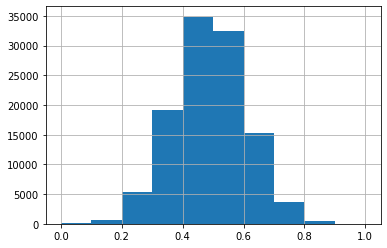

x19


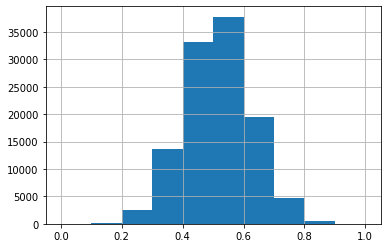

x20


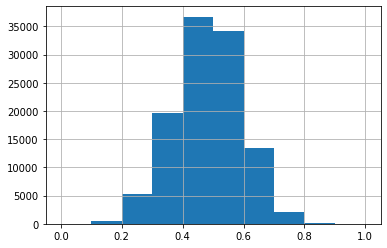

x21


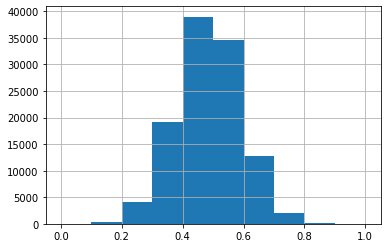

x22


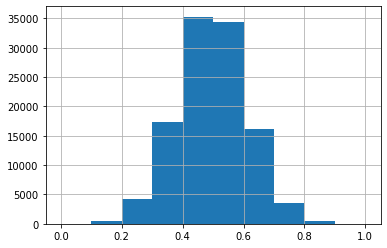

x23


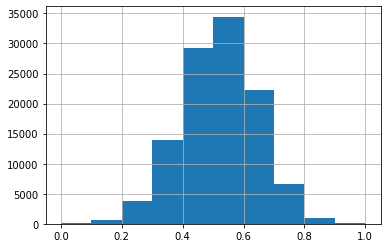

x25


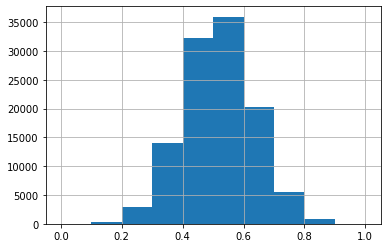

x26


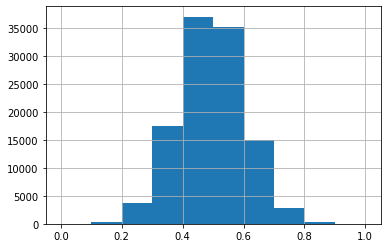

x27


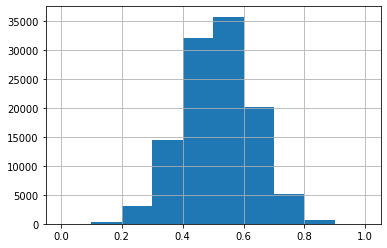

x28


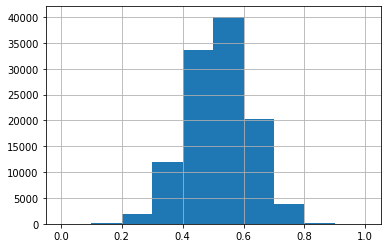

x31


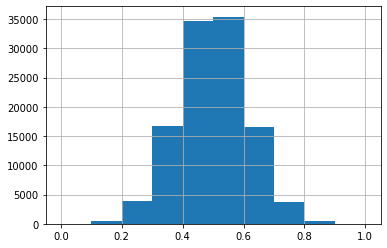

x32


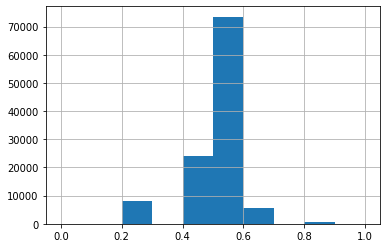

x33


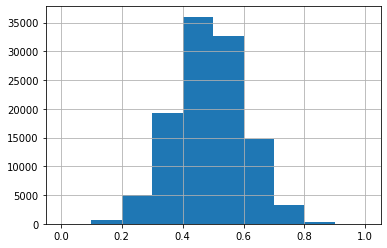

x34


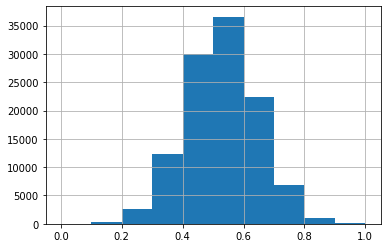

x35


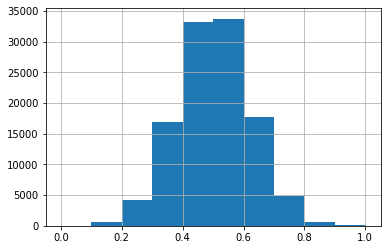

x36


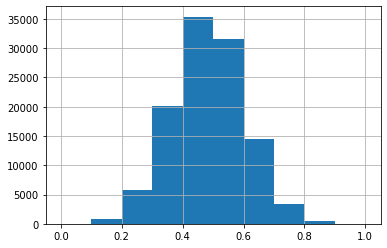

x37


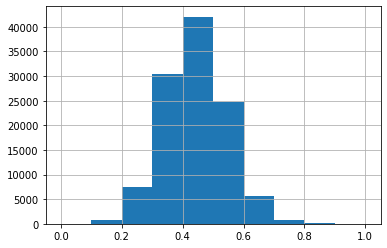

x38


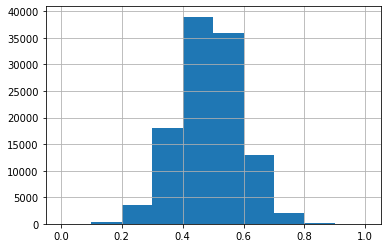

x39


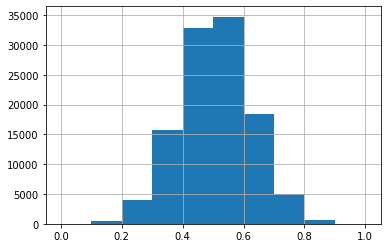

x40


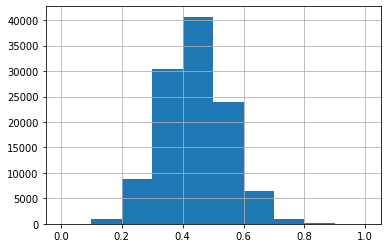

x41


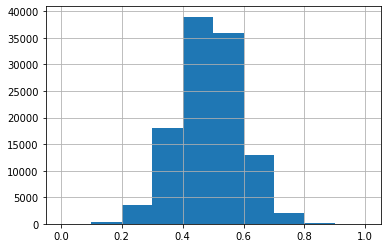

x42


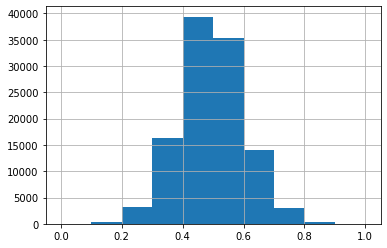

x43


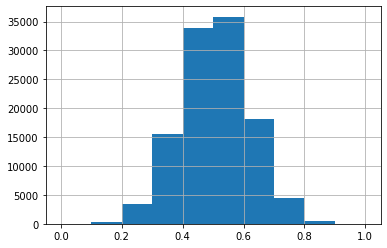

x44


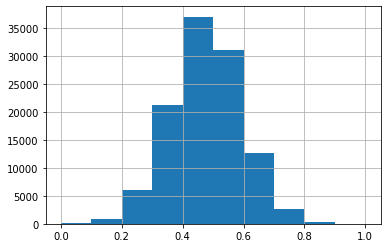

x45


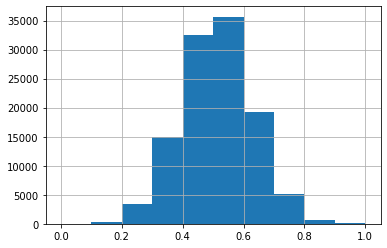

x46


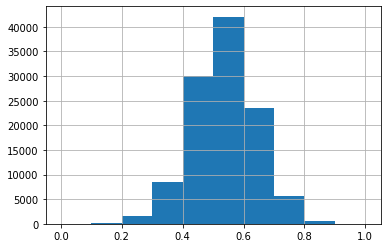

x47


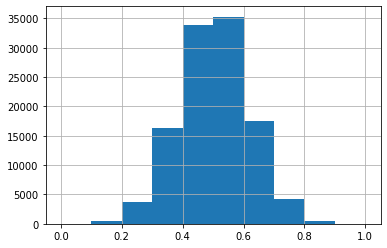

x48


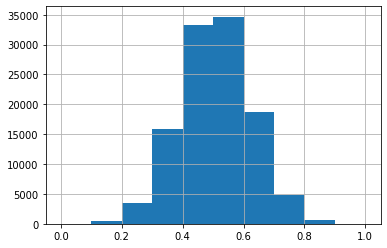

x49


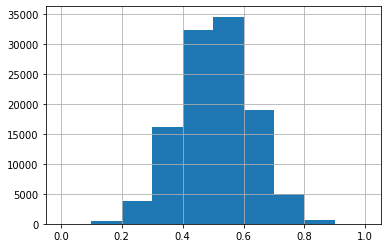

y


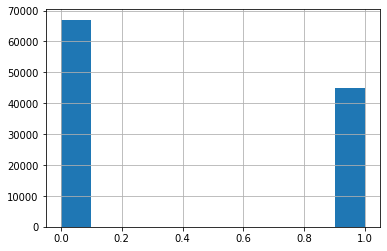

america


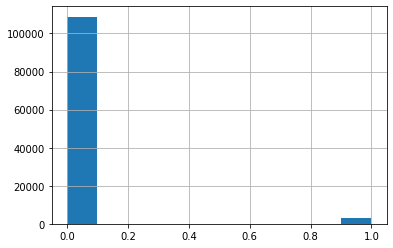

asia


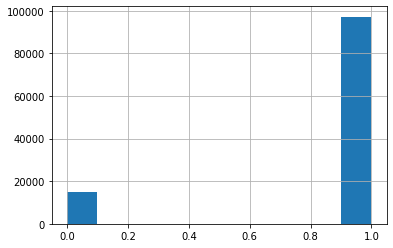

europe


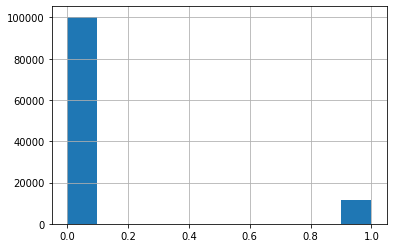

Apr


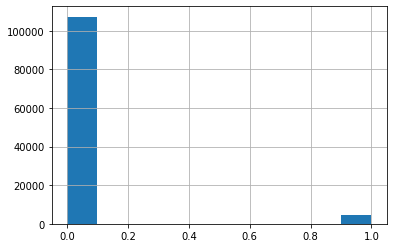

Aug


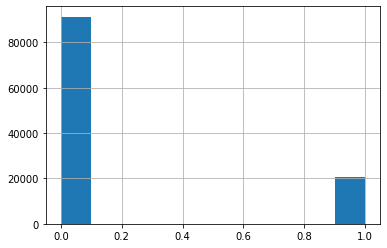

Dec


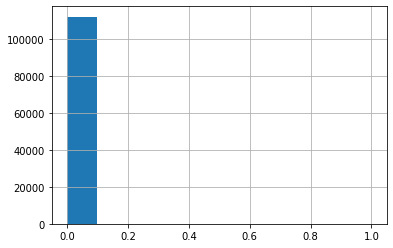

Feb


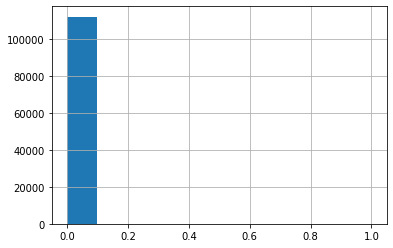

January


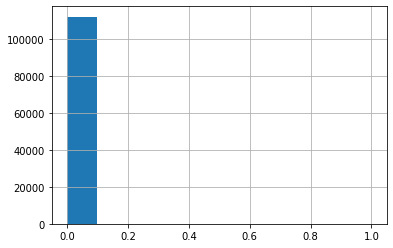

July


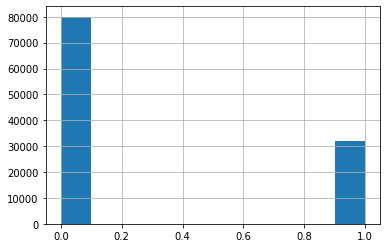

Jun


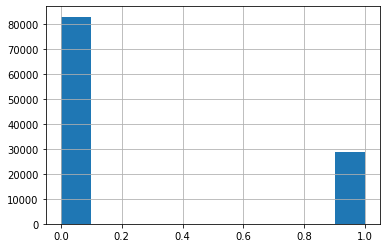

Mar


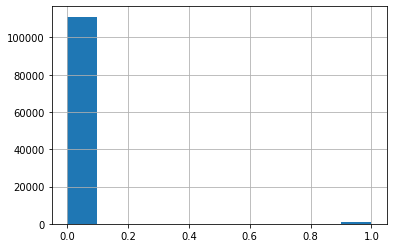

May


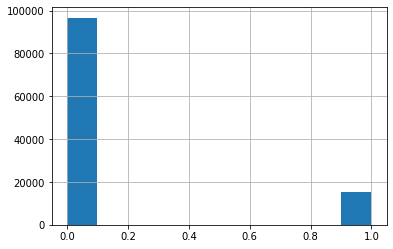

Nov


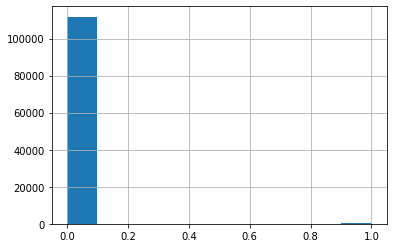

Oct


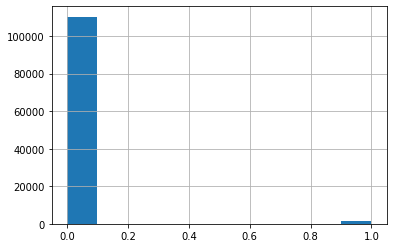

Sep


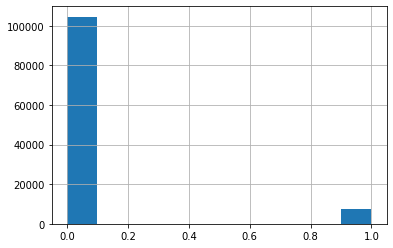

friday


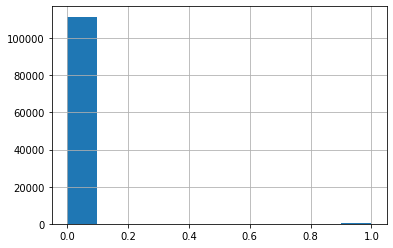

monday


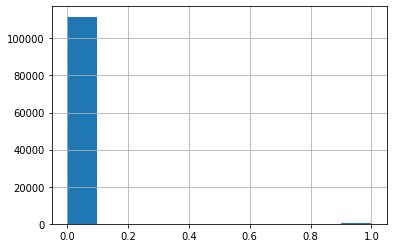

thursday


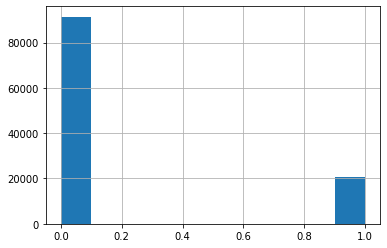

tuesday


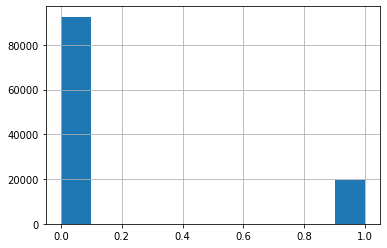

wednesday


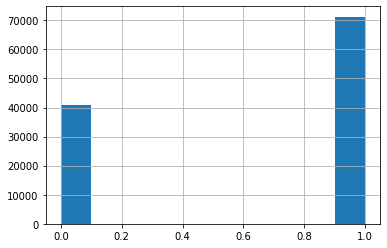

In [35]:
for i in scaled_data:
    scaled_data[i].hist()
    print(i)
    plt.show()

In [36]:
scaled_data.shape

(112000, 68)

There seems to be an unbalance in the 'Y' values. I will downsample the '0' Values to obtain a balanced set

In [37]:
y0_index = data[data['y'] == 0].index.values.astype(int)
y1_index = data[data['y'] == 1].index.values.astype(int)

In [38]:
y0_n=len(y0_index)
y1_n=len(y1_index)

In [39]:
y0_index_dsample = np.random.choice(y0_index, size=y1_n, replace=False)
data_dsample=data.iloc[y1_index].append(data.iloc[y0_index_dsample])
data_dsample=data_dsample.drop('index', axis=1)
data_dsample=data_dsample.reset_index()
data_dsample=data_dsample.drop('index', axis=1)

1    44958
0    44958
Name: y, dtype: int64


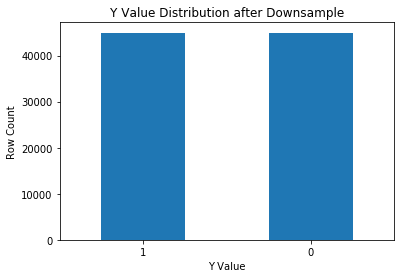

In [40]:
data_dsample['y'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Y Value')
plt.ylabel('Row Count')
plt.title('Y Value Distribution after Downsample')
print(data_dsample['y'].value_counts())

0.0    44958
1.0    44958
Name: y, dtype: int64


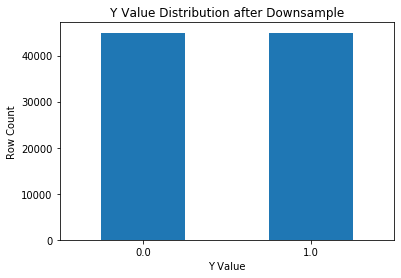

In [41]:
y0_index = scaled_data[scaled_data['y'] == 0].index.values.astype(int)
y1_index = scaled_data[scaled_data['y'] == 1].index.values.astype(int)

y0_n=len(y0_index)
y1_n=len(y1_index)

np.random.seed(7717)
y0_index_dsample = np.random.choice(y0_index, size=y1_n, replace=False)
scaled_data_dsample=scaled_data.iloc[y1_index].append(scaled_data.iloc[y0_index_dsample])
#scaled_data_dsample=scaled_data_dsample.drop('index', axis=1)
scaled_data_dsample=scaled_data_dsample.reset_index()
scaled_data_dsample=scaled_data_dsample.drop('index', axis=1)

scaled_data_dsample['y'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Y Value')
plt.ylabel('Row Count')
plt.title('Y Value Distribution after Downsample')
print(scaled_data_dsample['y'].value_counts())

In [42]:
data_dsample.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,Mar,May,Nov,Oct,Sep,friday,monday,thursday,tuesday,wednesday
0,0.517572,-0.955143,-11.284554,8.103776,-1.618281,0.306155,-16.406893,-59.551993,-3.520720,7.970330,...,0,1,0,0,0,0,0,0,0,1
1,-0.057574,4.325903,-8.303166,4.429269,16.766454,10.181928,-12.072179,-19.009709,10.383341,-6.079788,...,0,0,0,0,0,0,0,0,0,1
2,-0.361890,-7.029364,-7.274896,-11.787074,-1.333007,2.471724,-10.577151,-55.999040,0.597259,1.256774,...,0,0,0,0,0,0,0,0,1,0
3,0.176311,5.265634,-0.489324,1.456979,1.948639,-6.418719,-0.711440,21.971377,-1.640353,2.906685,...,0,0,0,0,0,0,0,0,0,1
4,-0.049336,-6.126525,-9.684533,2.538255,1.566541,-5.530198,-14.080584,15.341986,-4.676181,6.393256,...,0,0,0,0,0,0,0,0,1,0


In [43]:
scaled_data_dsample.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,Mar,May,Nov,Oct,Sep,friday,monday,thursday,tuesday,wednesday
0,0.660785,0.466645,0.391326,0.585895,0.490708,0.491965,0.391326,0.368826,0.445269,0.665525,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.480685,0.563961,0.415577,0.536494,0.826715,0.634322,0.415577,0.491437,0.626451,0.397491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.385393,0.354711,0.423941,0.318482,0.495922,0.523181,0.423941,0.379571,0.498930,0.537450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.553923,0.581278,0.479135,0.496535,0.555898,0.395027,0.479135,0.615375,0.469772,0.568926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.483265,0.371349,0.404341,0.511072,0.548915,0.407835,0.404341,0.595326,0.430212,0.635439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [45]:
#test set
test_y=test_set['y'].astype(float)
test_x=test_set.drop('y', axis=1)
print(test_x.shape)
#test Sclaled set
test_s_y=scaled_Tdata['y'].astype(float)
test_s_x=scaled_Tdata.drop('y', axis=1)
print(test_s_x.shape)

(47543, 67)
(47543, 67)


In [46]:

rf_Kfold=KFold(n_splits=5, shuffle=True, random_state=8080)
lr_Kfold=KFold(n_splits=5, shuffle=True, random_state=7070)
xg_Kfold=KFold(n_splits=5, shuffle=True, random_state=6060)
rf=RandomForestClassifier()
target_data=data_dsample['y'].astype(float)
train_data=data_dsample.drop('y', axis=1)


In [47]:
target_data

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
89911    0.0
89912    0.0
89913    0.0
89914    0.0
89915    0.0
Name: y, Length: 89916, dtype: float64

### Random Forrest Unscaled Data
Model Setup

In [48]:
target_data=data_dsample['y'].astype(float)
train_data=data_dsample.drop('y', axis=1)
rf_oof_predict=np.zeros(data_dsample.shape[0])
for train_idx, test_idx in rf_Kfold.split(data_dsample):
    rf.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    rf_oof_predict[test_idx]=rf.predict_proba(train_data.iloc[test_idx])[:,1]
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))
    

D:\Masters\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fold ROC score is 0.946436
Fold ROC score is 0.950938
Fold ROC score is 0.945951
Fold ROC score is 0.944783
Fold ROC score is 0.944860


Test the Model using the test set.

Fold ROC score for test set is is 0.944703


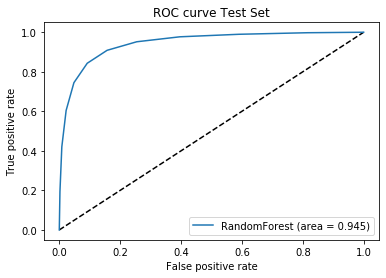

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
rf_testSet_predict=np.zeros(test_set.shape[0])
rf_testSet_predict=rf.predict_proba(test_x)[:,1]
rf_testSet_predict_val=rf.predict(test_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_y,rf_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_y, rf_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RandomForest (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for the Random Forest Model with unscaled data

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, rf_testSet_predict_val)
print(confusion_matrix)

[[25874  2615]
 [ 2989 16065]]


In [51]:
from sklearn.metrics import classification_report
print(classification_report(test_y, rf_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     28489
         1.0       0.86      0.84      0.85     19054

    accuracy                           0.88     47543
   macro avg       0.88      0.88      0.88     47543
weighted avg       0.88      0.88      0.88     47543



Feature Importance  --  Random Forrest - Unscaled Data

Feature ranking for Random Forest Using the unscaled Data:


Text(0, 0.5, 'Feature Name')

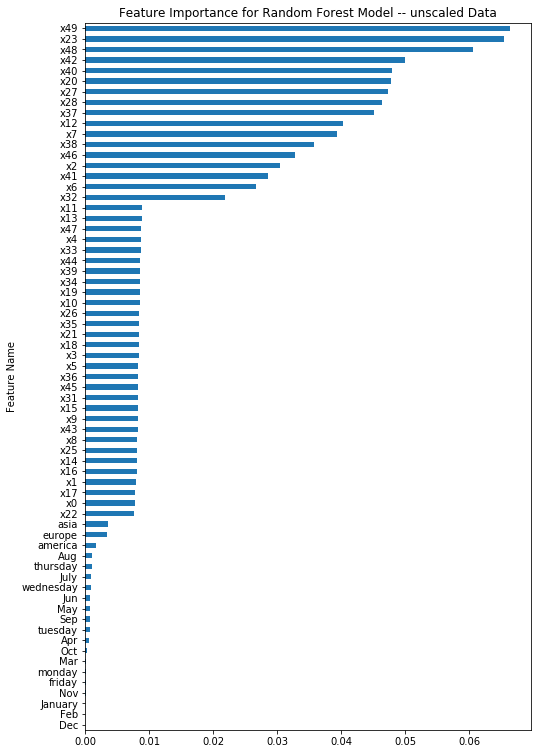

In [52]:
importances = rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=test_s_x.columns).sort_values(ascending=True)


#Print the feature ranking
print("Feature ranking for Random Forest Using the unscaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for Random Forest Model -- unscaled Data")
plt.ylabel("Feature Name")

#### Reduce the features to the top 17, on training and test set.

In [53]:
feature_imp = pd.DataFrame(feature_imp)

topFeatures = feature_imp.iloc[50:,0].index

topFeatureTrainDataX = train_data.loc[:,topFeatures]

topFeatureTestDataX = test_x.loc[:,topFeatures]
topFeatureTrainDataX
#topFeatureTestData


,x32,x6,x41,x2,x46,x38,x7,x12,x37,x28,x27,x20,x40,x42,x48,x23,x49
0,0.00,-16.406893,18.324901,-11.284554,-63.264957,16.569811,-59.551993,1.760363,-1959.13,13.130818,11.777154,14.109381,-25.680540,-3.768967,-0.103023,22.521537,-15.506133
1,-0.00,-12.072179,16.496565,-8.303166,-38.809867,14.916586,-19.009709,-6.253700,-1468.83,20.698894,9.249216,7.606745,0.270982,-0.478700,-0.850889,-8.209821,2.447823
2,-0.01,-10.577151,10.785104,-7.274896,42.439136,9.752147,-55.999040,25.168383,881.72,-25.302481,-2.069653,8.037590,-36.931166,0.074189,2.099866,16.058157,4.018310
3,0.01,-0.711440,10.760015,-0.489324,-15.561450,9.729461,21.971377,-3.543620,240.91,6.991556,0.089138,-9.665735,28.710520,-2.513466,0.185569,-25.527982,1.331215
4,0.02,-14.080584,4.950968,-9.684533,-48.358670,4.476783,15.341986,6.076056,-769.05,15.666894,-3.925342,-8.406620,9.768317,-7.763429,-0.644268,-8.643250,-5.858072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89911,0.01,-33.949570,-28.907490,-23.350292,-30.836840,-26.138840,-0.437445,7.719905,-1266.44,-7.249126,-8.076863,5.679294,-22.361674,-6.533553,2.357175,24.319609,-2.227657
89912,-0.00,19.202767,22.300072,13.207537,-29.268986,20.164255,-31.885545,5.309699,1524.79,-18.747972,-4.962874,-2.315710,-2.546208,-8.835528,0.118554,-2.592008,-24.557987
89913,-0.01,-1.789981,4.269130,-1.231137,1.280857,3.860249,-24.278216,-5.482499,545.88,-16.587306,-9.442172,5.807050,-34.759068,-3.596480,-0.552558,20.174279,12.789839
89914,0.01,4.071970,30.508894,2.800674,-34.891181,27.586868,-46.705131,2.577603,248.10,-13.654670,5.458886,7.337103,-15.159431,-0.196140,2.236491,12.362313,-18.843084


In [54]:
# Model using the reduced feature set

rf_oof_predict=np.zeros(data_dsample.shape[0])
for train_idx, test_idx in rf_Kfold.split(data_dsample):
    rf.fit(topFeatureTrainDataX.iloc[train_idx],target_data.iloc[train_idx])
    rf_oof_predict[test_idx]=rf.predict(topFeatureTrainDataX.iloc[test_idx])
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))

Fold ROC score is 0.910950
Fold ROC score is 0.917167
Fold ROC score is 0.913391
Fold ROC score is 0.913531
Fold ROC score is 0.911284


Test the Random Forest model with the test data for top features.

Fold ROC score for test set is is 0.967180


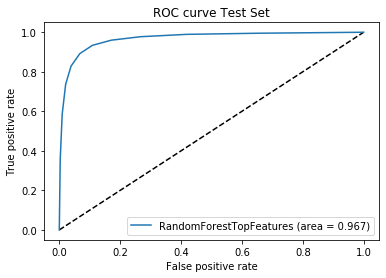

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
rf_testSet_predict=np.zeros(topFeatureTestDataX.shape[0])
rf_testSet_predict=rf.predict_proba(topFeatureTestDataX)[:,1]
rf_testSet_predict_val=rf.predict(topFeatureTestDataX)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_y,rf_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_y, rf_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RandomForestTopFeatures (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for random forest on test set for top Features

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, rf_testSet_predict_val)
print(confusion_matrix)

[[26565  1924]
 [ 2058 16996]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(test_y, rf_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     28489
         1.0       0.90      0.89      0.90     19054

    accuracy                           0.92     47543
   macro avg       0.91      0.91      0.91     47543
weighted avg       0.92      0.92      0.92     47543



Random Forest Feature Importance for Top Features

Feature ranking for Random Forest Using the Unscaled Data:


Text(0, 0.5, 'Feature Name')

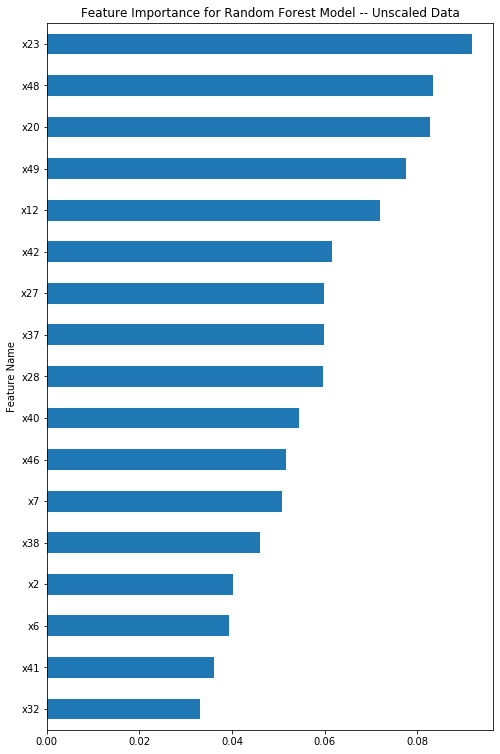

In [58]:
feature_imp = pd.Series(rf.feature_importances_, index=topFeatureTestDataX.columns).sort_values(ascending=True)
#feature_imp = pd.DataFrame(feature_imp)

#Print the feature ranking
print("Feature ranking for Random Forest Using the Unscaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for Random Forest Model -- Unscaled Data")
plt.ylabel("Feature Name")

### Random Forrest Scaled Data
Model Setup

In [59]:
target_data=scaled_data_dsample['y'].astype(float)
train_data=scaled_data_dsample.drop('y', axis=1)

rf_oof_predict=np.zeros(scaled_data_dsample.shape[0])
for train_idx, test_idx in rf_Kfold.split(scaled_data_dsample):
    rf.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    rf_oof_predict[test_idx]=rf.predict_proba(train_data.iloc[test_idx])[:,1]
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))
    

Fold ROC score is 0.945383
Fold ROC score is 0.946469
Fold ROC score is 0.947075
Fold ROC score is 0.946683
Fold ROC score is 0.942598


Test the model with using the test set

Fold ROC score for test set is is 0.904828


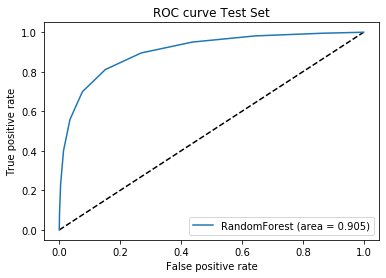

In [60]:
from sklearn.metrics import auc
rf_testSet_predict=np.zeros(scaled_Tdata.shape[0])
rf_testSet_predict=rf.predict_proba(test_s_x)[:,1]
rf_testSet_predict_val=rf.predict(test_s_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_s_y,rf_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_s_y, rf_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RandomForest (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for the Scaled Data

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_s_y, rf_testSet_predict_val)
print(confusion_matrix)

[[26328  2161]
 [ 5738 13316]]


In [62]:
from sklearn.metrics import classification_report
print(classification_report(test_s_y, rf_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87     28489
         1.0       0.86      0.70      0.77     19054

    accuracy                           0.83     47543
   macro avg       0.84      0.81      0.82     47543
weighted avg       0.84      0.83      0.83     47543



Feature ranking for Random Forest Using the Scaled Data:


Text(0, 0.5, 'Feature Name')

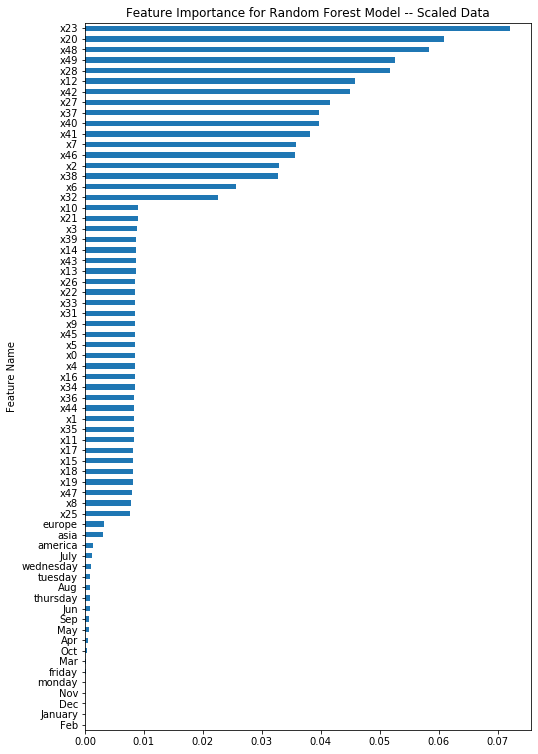

In [63]:
importances = rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=test_s_x.columns).sort_values(ascending=True)


#Print the feature ranking
print("Feature ranking for Random Forest Using the Scaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for Random Forest Model -- Scaled Data")
plt.ylabel("Feature Name")

### Logistic Regression Unscaled Data
Model Setup

In [64]:
target_data=data_dsample['y'].astype(float)
train_data=data_dsample.drop('y', axis=1)

lr=LogisticRegression(solver='liblinear')
lr_oof_predict=np.zeros(data_dsample.shape[0])
for train_idx, test_idx in lr_Kfold.split(data_dsample):
    result_model=lr.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    lr_oof_predict[test_idx]=lr.predict_proba(train_data.iloc[test_idx])[:,1]
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],lr_oof_predict[test_idx]))
    
    

Fold ROC score is 0.757549
Fold ROC score is 0.764768
Fold ROC score is 0.762179
Fold ROC score is 0.756651
Fold ROC score is 0.759580


In [65]:
coefficients = pd.concat([pd.DataFrame(train_data.columns),pd.DataFrame(np.transpose(result_model.coef_))], axis = 1)
coefficients

,0,0
0,x0,-0.009718
1,x1,-0.000740
2,x2,-0.009458
3,x3,-0.000753
4,x4,-0.000285
...,...,...
62,friday,0.014500
63,monday,-0.033201
64,thursday,-0.074284
65,tuesday,-0.021370


Test the logistic regression model with the test data.

Fold ROC score for test set is is 0.759388


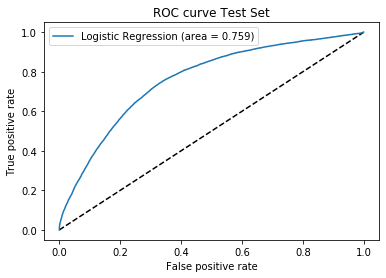

In [66]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
lr_testSet_predict=np.zeros(test_set.shape[0])
lr_testSet_predict=lr.predict_proba(test_x)[:,1]
lr_testSet_predict_val=lr.predict(test_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_y,lr_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_y, lr_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for logistic regression on test set

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, lr_testSet_predict_val)
print(confusion_matrix)

[[20597  7892]
 [ 6122 12932]]


In [68]:
from sklearn.metrics import classification_report
print(classification_report(test_y, lr_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.75     28489
         1.0       0.62      0.68      0.65     19054

    accuracy                           0.71     47543
   macro avg       0.70      0.70      0.70     47543
weighted avg       0.71      0.71      0.71     47543



### Logistic Regression Scaled Data
Model Setup

In [69]:
target_data=scaled_data_dsample['y'].astype(float)
train_data=scaled_data_dsample.drop('y', axis=1)

lr=LogisticRegression(solver='liblinear')
lr_oof_predict=np.zeros(scaled_data_dsample.shape[0])
for train_idx, test_idx in lr_Kfold.split(scaled_data_dsample):
    lr.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    lr_oof_predict[test_idx]=lr.predict_proba(train_data.iloc[test_idx])[:,1]
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],lr_oof_predict[test_idx]))
    
    

Fold ROC score is 0.766259
Fold ROC score is 0.762463
Fold ROC score is 0.758329
Fold ROC score is 0.755225
Fold ROC score is 0.760205


In [70]:
coefficients = pd.concat([pd.DataFrame(train_data.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients

,0,0
0,x0,-0.084476
1,x1,-0.015325
2,x2,-1.625452
3,x3,-0.007088
4,x4,-0.023512
...,...,...
62,friday,0.294682
63,monday,0.062112
64,thursday,0.149802
65,tuesday,0.199856


Test the logistic regression model with the test data.

Fold ROC score for test set is is 0.759382


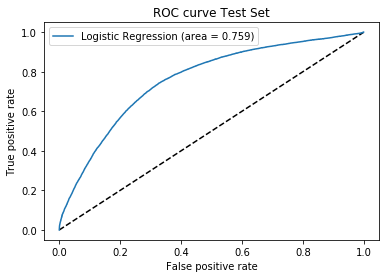

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
lr_testSet_predict=np.zeros(test_set.shape[0])
lr_testSet_predict=lr.predict_proba(test_s_x)[:,1]
lr_testSet_predict_val=lr.predict(test_s_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_s_y,lr_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_s_y, lr_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_s_y, lr_testSet_predict_val)
print(confusion_matrix)

[[24730  3759]
 [10908  8146]]


In [73]:
from sklearn.metrics import classification_report
print(classification_report(test_s_y, lr_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77     28489
         1.0       0.68      0.43      0.53     19054

    accuracy                           0.69     47543
   macro avg       0.69      0.65      0.65     47543
weighted avg       0.69      0.69      0.67     47543



### xgBoost Model with Unscaled Data
Model Setup

In [74]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 10, alpha = 20, n_estimators = 10)



In [75]:
target_data=data_dsample['y'].astype(float)
train_data=data_dsample.drop('y', axis=1)


xg_oof_predict=np.zeros(data_dsample.shape[0])
for train_idx, test_idx in xg_Kfold.split(data_dsample):
    xg_reg.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    xg_oof_predict[test_idx]=xg_reg.predict(train_data.iloc[test_idx])
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))

Fold ROC score is 0.944852
Fold ROC score is 0.942241
Fold ROC score is 0.945362
Fold ROC score is 0.945884
Fold ROC score is 0.949820


Test the xgBoost model with the test data.

Fold ROC score for test set is is 0.929679


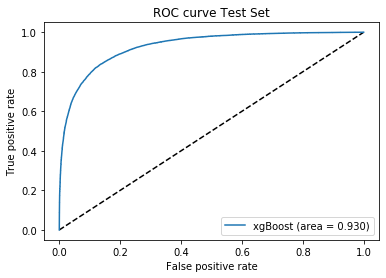

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
xg_testSet_predict=np.zeros(test_set.shape[0])
xg_testSet_predict=xg_reg.predict_proba(test_x)[:,1]
xg_testSet_predict_val=xg_reg.predict(test_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_y,xg_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_y, xg_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgBoost (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for xgBoost on test set

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, xg_testSet_predict_val)
print(confusion_matrix)

[[24176  4313]
 [ 2819 16235]]


In [78]:
from sklearn.metrics import classification_report
print(classification_report(test_y, xg_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     28489
         1.0       0.79      0.85      0.82     19054

    accuracy                           0.85     47543
   macro avg       0.84      0.85      0.85     47543
weighted avg       0.85      0.85      0.85     47543



xgBoost Feature Importance

Feature ranking for xgBoost Using the Unscaled Data:


Text(0, 0.5, 'Feature Name')

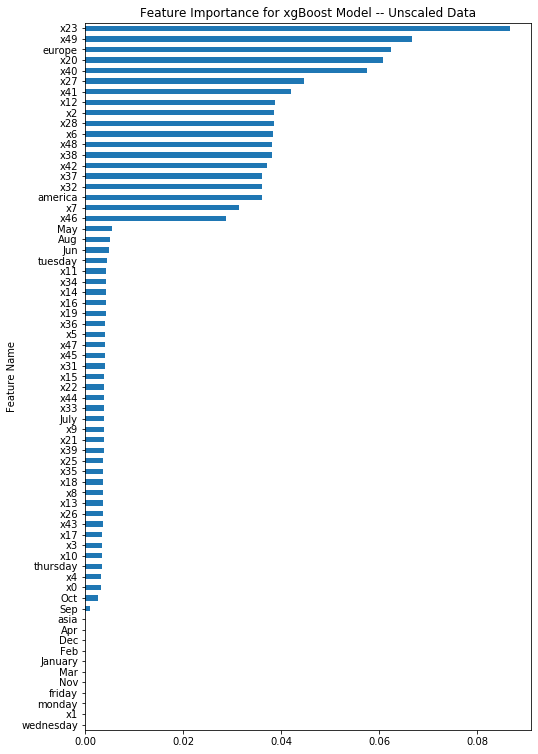

In [79]:
feature_imp = pd.Series(xg_reg.feature_importances_, index=test_x.columns).sort_values(ascending=True)
#feature_imp = pd.DataFrame(feature_imp)

#Print the feature ranking
print("Feature ranking for xgBoost Using the Unscaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for xgBoost Model -- Unscaled Data")
plt.ylabel("Feature Name")

#### Reduce the features to the top 20, on training and test set.

In [80]:
feature_imp = pd.DataFrame(feature_imp)

topFeatures = feature_imp.iloc[47:,0].index

topFeatureTrainDataX = train_data.loc[:,topFeatures]

topFeatureTestDataX = test_x.loc[:,topFeatures]
#topFeatureTrainData
#topFeatureTestData


In [81]:
# Model using the reduced feature set

xg_oof_predict=np.zeros(data_dsample.shape[0])
for train_idx, test_idx in xg_Kfold.split(data_dsample):
    xg_reg.fit(topFeatureTrainDataX.iloc[train_idx],target_data.iloc[train_idx])
    xg_oof_predict[test_idx]=xg_reg.predict(topFeatureTrainDataX.iloc[test_idx])
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))

Fold ROC score is 0.944852
Fold ROC score is 0.942241
Fold ROC score is 0.945362
Fold ROC score is 0.945884
Fold ROC score is 0.949820


Test the xgBoost model with the test data for top features.

Fold ROC score for test set is is 0.928562


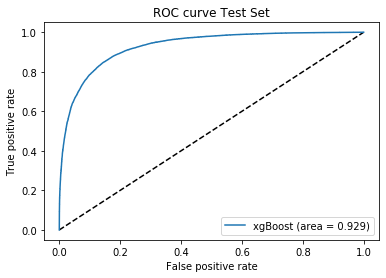

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
xg_testSet_predict=np.zeros(topFeatureTestDataX.shape[0])
xg_testSet_predict=xg_reg.predict_proba(topFeatureTestDataX)[:,1]
xg_testSet_predict_val=xg_reg.predict(topFeatureTestDataX)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_y,xg_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_y, xg_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgBoost (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for xgBoost on test set for top Features

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, xg_testSet_predict_val)
print(confusion_matrix)

[[24411  4078]
 [ 2940 16114]]


In [84]:
from sklearn.metrics import classification_report
print(classification_report(test_y, xg_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87     28489
         1.0       0.80      0.85      0.82     19054

    accuracy                           0.85     47543
   macro avg       0.85      0.85      0.85     47543
weighted avg       0.85      0.85      0.85     47543



xgBoost Feature Importance for Top Features

Feature ranking for xgBoost Using the Unscaled Data:


Text(0, 0.5, 'Feature Name')

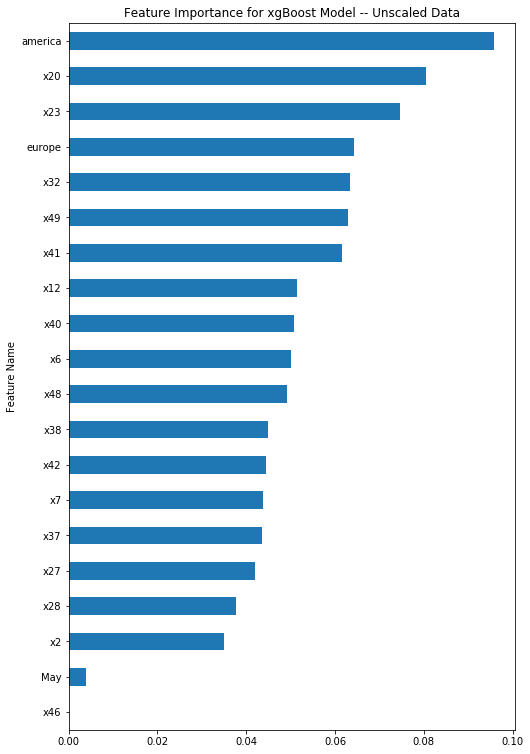

In [85]:
feature_imp = pd.Series(xg_reg.feature_importances_, index=topFeatureTestDataX.columns).sort_values(ascending=True)
#feature_imp = pd.DataFrame(feature_imp)

#Print the feature ranking
print("Feature ranking for xgBoost Using the Unscaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for xgBoost Model -- Unscaled Data")
plt.ylabel("Feature Name")

### xgBoost Model with Scaled Data
Model Setup

In [86]:
target_data=scaled_data_dsample['y'].astype(float)
train_data=scaled_data_dsample.drop('y', axis=1)

xg_oof_predict=np.zeros(scaled_data_dsample.shape[0])
for train_idx, test_idx in xg_Kfold.split(scaled_data_dsample):
    xg_reg.fit(train_data.iloc[train_idx],target_data.iloc[train_idx])
    xg_oof_predict[test_idx]=xg_reg.predict(train_data.iloc[test_idx])
    #print(xg_reg)
    #print(target_data[test_idx].unique)
    print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],rf_oof_predict[test_idx]))

Fold ROC score is 0.944852
Fold ROC score is 0.942241
Fold ROC score is 0.945362
Fold ROC score is 0.945884
Fold ROC score is 0.949820


Test the xgBoost model with the test data.

Fold ROC score for test set is is 0.869792


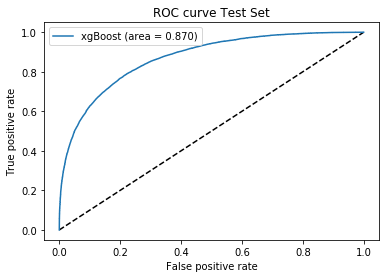

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
xg_testSet_predict=np.zeros(test_set.shape[0])
xg_testSet_predict=xg_reg.predict_proba(test_s_x)[:,1]
xg_testSet_predict_val=xg_reg.predict(test_s_x)
print("Fold ROC score for test set is is %f" % roc_auc_score(test_s_y,xg_testSet_predict))
fpr, tpr, thresholds = roc_curve(test_s_y, xg_testSet_predict)
auc= auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgBoost (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test Set')
plt.legend(loc='best')
plt.show()

Confusion Matrix for xgBoost on test set

In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_s_y, xg_testSet_predict_val)
print(confusion_matrix)

[[24306  4183]
 [ 5730 13324]]


In [89]:
from sklearn.metrics import classification_report
print(classification_report(test_s_y, xg_testSet_predict_val))

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83     28489
         1.0       0.76      0.70      0.73     19054

    accuracy                           0.79     47543
   macro avg       0.79      0.78      0.78     47543
weighted avg       0.79      0.79      0.79     47543



xgBoost Feature Importance

Feature ranking for xgBoost Using the Scaled Data:


Text(0, 0.5, 'Feature Name')

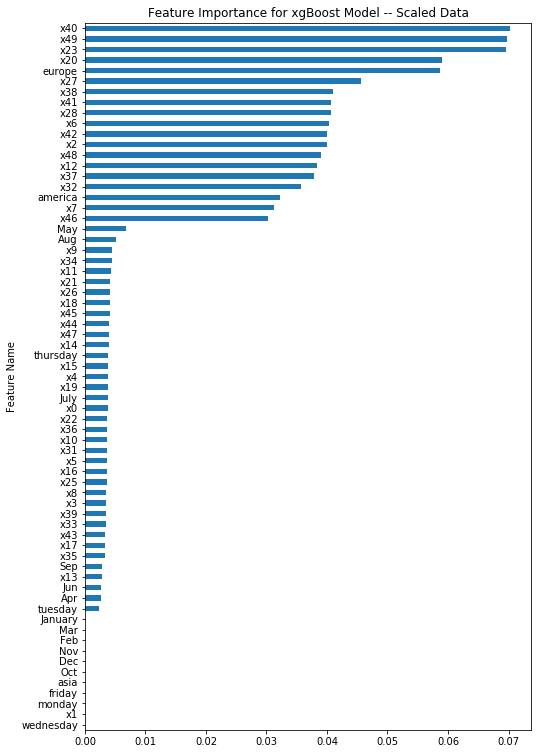

In [90]:
feature_imp = pd.Series(xg_reg.feature_importances_, index=test_s_x.columns).sort_values(ascending=True)


#Print the feature ranking
print("Feature ranking for xgBoost Using the Scaled Data:")
plt.figure(figsize=(8,13))
feature_imp.plot(kind="barh")
plt.title("Feature Importance for xgBoost Model -- Scaled Data")
plt.ylabel("Feature Name")